In [1]:
#  Reward function shaping in this script
#  TODO extend for the discrete case also. Right now, discrete uses only sparse rewards

In [1]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle

In [2]:
df_train = pd.read_csv('../data/rl_train_set_scaled.csv')
df_val =  pd.read_csv('../data/rl_val_set_scaled.csv')
df_test = pd.read_csv('../data/rl_test_set_scaled.csv')

In [3]:
# df_train_disc = pd.read_csv('../data/rl_train_data_discrete.csv')
# df_val_disc = pd.read_csv('../data/rl_val_data_discrete.csv')
# df_test_disc = pd.read_csv('../data/rl_test_data_discrete.csv')

In [3]:
df_train.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input,reward
0,0.000000,11,6898241400,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.223817,0.500000,0.00,0.0,0.0,0
1,0.222560,11,6898255800,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.574861,0.707254,0.223281,0.416667,0.00,0.0,0.0,0
2,0.356608,11,6898270200,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.629131,0.723746,0.222629,0.416667,0.25,0.0,0.0,0
3,0.452837,11,6898284600,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.659814,0.726688,0.221953,0.458333,0.25,0.0,0.0,0
4,0.527957,11,6898299000,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.675701,0.699627,0.221464,0.458333,0.25,0.0,0.0,0


In [4]:
len(df_train)

195567

In [5]:
df_test.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input,reward
0,0.000000,3,7245486000,0.0,0.412568,0.0,0.0,0,0,1,...,0.704767,0.492908,0.805762,0.717533,0.215559,0.125000,0.25,0.0,2.0,0
1,0.222560,3,7245500400,0.0,0.412568,0.0,0.0,0,0,1,...,0.705252,0.492908,0.807565,0.687860,0.215192,0.291667,0.50,0.0,2.0,0
2,0.356608,3,7245514800,0.0,0.412568,0.0,0.0,0,0,1,...,0.705734,0.492908,0.808916,0.665636,0.214924,0.208333,0.50,0.0,2.0,0
3,0.452837,3,7245529200,0.0,0.412568,0.0,0.0,0,0,1,...,0.706212,0.492908,0.810522,0.681912,0.214586,0.208333,0.25,0.0,2.0,0
4,0.527957,3,7245543600,0.0,0.412568,0.0,0.0,0,0,1,...,0.706686,0.492908,0.812997,0.720697,0.214016,0.208333,0.50,0.0,2.0,0


In [7]:
# Smaller rewards to improve stability in continuous models
df_train.loc[df_train['reward'] > 15,'reward'] = 15
df_train.loc[df_train['reward'] < -15,'reward'] = -15

df_val.loc[df_val['reward'] > 15,'reward'] = 15
df_val.loc[df_val['reward'] < -15,'reward'] = -15

df_test.loc[df_test['reward'] > 15,'reward'] = 15
df_test.loc[df_test['reward'] < -15,'reward'] = -15

In [9]:
# Similar process in discrete models to facilitate comparisons
# df_train_disc.loc[df_train_disc['reward'] > 15,'reward'] = 15
# df_train_disc.loc[df_train_disc['reward'] < -15,'reward'] = -15

# df_val_disc.loc[df_val_disc['reward'] > 15,'reward'] = 15
# df_val_disc.loc[df_val_disc['reward'] < -15,'reward'] = -15

# df_test_disc.loc[df_test_disc['reward'] > 15,'reward'] = 15
# df_test_disc.loc[df_test_disc['reward'] < -15,'reward'] = -15

In [10]:
orig_df = pd.read_csv('../data/MIMICtable.csv')

In [11]:
# lactate - target is 0.5 to 1 mmol/l
# SOFA - 0
#  GCS - 0
#  mechvent = 0
# MAP is normally between 65 and 110 mmHg

In [12]:
# s1 = orig_df['SOFA'].values
# s2 = orig_df['SOFA'].values
# s2 = np.insert(s2,0,9)
# s2 = np.delete(s2, -1)
# print len(s1), len(s2)

In [13]:
# pd.Series(s2-s1).hist(bins=100)

In [14]:
# l1 = orig_df['Arterial_lactate'].values
# l2 = orig_df['Arterial_lactate'].values
# l2 = np.insert(l2,0,9)
# l2 = np.delete(l2, -1)
# print len(l1), len(l2)

In [15]:
c0 = -0.1/4
c1 = -0.5/4
c2 = -2

In [16]:
# c0 = -0.1/2
# c1 = -0.5/2
# c2 = -2

In [17]:
# add rewards
orig_df['shaped_reward'] = 0
for i in orig_df.index:
    if i == 0:
        continue
    if orig_df.loc[i, 'icustayid'] == orig_df.loc[i-1, 'icustayid']:
        sofa_cur = orig_df.loc[i,'SOFA']
        sofa_prev = orig_df.loc[i-1,'SOFA']
        lact_cur = orig_df.loc[i,'Arterial_lactate']
        lact_prev = orig_df.loc[i-1,'Arterial_lactate']
        reward = 0
        if sofa_cur == sofa_prev and sofa_cur != 0:
            reward += c0
        reward += c1*(sofa_cur-sofa_prev)
        reward += c2*np.tanh(lact_cur - lact_prev)
        orig_df.loc[i-1,'shaped_reward'] = reward
    if i % 10000 == 0:
        print(i)

# if orig_df.ix[len(orig_df)-1, 'died_in_hosp'] == 1:
#     orig_df.ix[len(orig_df)-1, 'shaped_reward'] = -100
# elif orig_df.ix[len(orig_df)-1, 'died_in_hosp'] == 0:
#      orig_df.ix[len(orig_df)-1, 'shaped_reward'] = 100
print (orig_df['shaped_reward'].value_counts())

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
-0.025000    39031
 0.000000    22507
 0.125000    12996
-0.125000    11289
 0.250000     6404
             ...  
-0.916293        1
 0.087861        1
-0.211756        1
 0.838874        1
 2.034402        1
Name: shaped_reward, Length: 53059, dtype: int64


 0     180896
 15     12660
-15      2011
Name: reward, dtype: int64

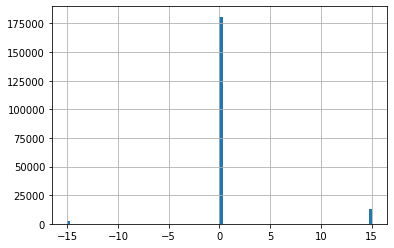

In [14]:
%matplotlib inline
df_train['reward'].hist(bins=100)
df_train['reward'].value_counts()#+df_test['reward'].value_counts()+df_val['reward'].value_counts()

In [19]:
train_ids = df_train['icustayid'].unique()
val_ids = df_val['icustayid'].unique()
test_ids = df_test['icustayid'].unique()

In [20]:
train_rewards = orig_df.loc[orig_df['icustayid'].isin(train_ids)]['shaped_reward']

In [21]:
# check this works as expected
val_rewards = orig_df.loc[orig_df['icustayid'].isin(val_ids)]['shaped_reward']

In [22]:
test_rewards = orig_df.loc[orig_df['icustayid'].isin(test_ids)]['shaped_reward']

In [23]:
len(orig_df)

278886

In [24]:
# check that this sums to the total number of data items -- needs to be re-run
len(df_train) + len(df_test) + len(df_val)

278886

In [25]:
df_train['reward'] += np.array(train_rewards)
df_val['reward'] += np.array(val_rewards)
df_test['reward'] += np.array(test_rewards)

In [27]:
# df_train1 = df_train.copy()
# df_val1 = df_val.copy()
# df_test1 = df_test.copy()

In [109]:
df_train = df_train1.copy()
df_val = df_val1.copy()
df_test = df_test1.copy()

In [110]:
uids = df_train['icustayid'].unique()
len_trajecties = []
for uid in uids:
    len_trajecties.append(len(df_train[df_train['icustayid']==uid]))

In [111]:
mid_len = int((sum(len_trajecties)-len(len_trajecties))/len(len_trajecties))//2+1

In [112]:
mid_len

7

In [113]:
############ 奖励测试 ##############
# uids = df_test['icustayid'].unique()
# length = 1
# C4 = 0.5#0.1
# for t in range(1,len(df_test)):
#     if df_test.loc[t,'icustayid']!=df_test.loc[t-1,'icustayid']:
#         length = 1
#         continue
#     df_test.loc[t,'reward']+= length*C4
#     length +=1
# length = 1
# for t in range(1,len(df_train)):
#     if df_train.loc[t,'icustayid']!=df_train.loc[t-1,'icustayid']:
#         length = 1
#         continue
#     df_train.loc[t,'reward']+= length*C4
#     length +=1
# length = 1
# for t in range(1,len(df_val)):
#     if df_val.loc[t,'icustayid']!=df_val.loc[t-1,'icustayid']:
#         length = 1
#         continue
#     df_val.loc[t,'reward']+= length*C4
#     length +=1
############ 奖励测试 ##############

# length = 0
# uid = 0 
# #C4 = 0.5#0.1
# C4 = 0.1
# for t in range(1,len(df_test)):
#     if df_test.loc[t,'icustayid']!=df_test.loc[t-1,'icustayid']:
#         length = 0
#         #len_curent = len_trajecties[uid]
#         uid =+1
#         continue
#     df_test.loc[t-1,'reward']+= (length-mid_len)*C4
#     length +=1
length = 0
uid = 0 
#C4 = 0.5#0.1
C4 = 0.10
for t in range(1,len(df_train)):
    if df_train.loc[t,'icustayid']!=df_train.loc[t-1,'icustayid']:
        length = 0
        uid =+1
        continue
    df_train.loc[t-1,'reward']+= (length-mid_len)*(C4+ length*0.003)
    length +=1
length = 0
uid = 0 
for t in range(1,len(df_test)):
    if df_test.loc[t,'icustayid']!=df_test.loc[t-1,'icustayid']:
        length = 0
        uid =+1
        continue
    df_test.loc[t-1,'reward']+= (length-mid_len)*(C4+ length*0.003)
    length +=1
length = 0
uid = 0 
for t in range(1,len(df_val)):
    if df_val.loc[t,'icustayid']!=df_val.loc[t-1,'icustayid']:
        length = 0
        uid =+1
        continue
    df_val.loc[t-1,'reward']+= (length-mid_len)*(C4+ length*0.003)
    length +=1
length = 1

# for t in range(1,len(df_train)):
#     if df_train.loc[t,'icustayid']!=df_train.loc[t-1,'icustayid']:
#         length = 1
#         continue
#     df_train.loc[t,'reward']+= length*C4
#     length +=1
# length = 1
# for t in range(1,len(df_val)):
#     if df_val.loc[t,'icustayid']!=df_val.loc[t-1,'icustayid']:
#         length = 1
#         continue
#     df_val.loc[t,'reward']+= length*C4
#     length +=1

In [6]:
unique_ids = df_test['icustayid'].unique()
phys_vals = []
gamma = 0.99
for uid in unique_ids:
    traj = df_test.loc[df_test['icustayid'] == uid]
    ret = 0
    reversed_traj = traj.iloc[::-1]
    for row in reversed_traj.index:
        ret = reversed_traj.loc[row,'reward'] + gamma*ret
    phys_vals.append(ret)
np.mean(phys_vals)

65.05348661945744

In [115]:
# df_train_disc['reward'] += np.array(train_rewards)
# df_val_disc['reward'] += np.array(val_rewards)
# df_test_disc['reward'] += np.array(test_rewards)

In [13]:
df_train.to_csv('../data_o/rl_train_data_final_or.csv',index=False)
df_val.to_csv('../data_o/rl_val_data_final_or.csv', index=False)
df_test.to_csv('../data_o/rl_test_data_final_or.csv',index=False)

In [ ]:
# df_train_disc.to_csv('../data/rl_train_data_final_disc.csv',index=False)
# df_val_disc.to_csv('../data/rl_val_data_final_disc.csv', index=False)
# df_test_disc.to_csv('../data/rl_test_data_final_disc.csv',index=False)

In [ ]:
train_rewards.head(n=20)

In [ ]:
df_train['reward'].head(n=20)